In [2]:
# Author(s) : Caleb Bean, Benjamin Hicks
# slurm.py
# Purpose: Python code used to generate slurm job scripts and execute them

import subprocess
import os
import matplotlib.pyplot as plt
import numpy as np

job_directory = '../LULESH/'
job_file_name = 'job-hw.sh'
job_path = job_directory+job_file_name

plot_directory = '../plots/'

email = 'caleb.bean@ufl.edu'
# Note that currently outfiles do not get produced and the output is only available via stdout
outfile_prefix = 'lulesh_out'
errfile_prefix = 'lulesh_err'
slurmrun_cmd = 'srun ./lulesh2.0 -s '

# SBATCH parameters
# Serial case shown below
lulesh_s_param = [5,8]
nodes_param = [1]*len(lulesh_s_param)
n_tasks_param = [1]*len(lulesh_s_param)
n_taskspernode_param = [1]*len(lulesh_s_param)

job_count = len(lulesh_s_param)



# Set one of these true for build
make_cmd_dict = {
            'SERIAL'    : True,
            'MPI'       : False,
            'OMP'       : False,
            'MPI+OMP'   : False
            }

sbatch_cmds_dict = {
    '#!/bin/bash'                           : [],
    '#SBATCH --mail-type=FAIL'              : [],
    '#SBATCH --mail-user='+email            : [],
    '#SBATCH --account=eel6763'             : [],
    '#SBATCH --qos=eel6763'                 : [],
    '#SBATCH --nodes='                      : nodes_param, # Fill this
    '#SBATCH --ntasks='                     : n_tasks_param, # Fill this
    '#SBATCH --ntasks-per-node='            : n_taskspernode_param, # Fill this
    '#SBATCH --cpus-per-task=1'             : [],
    '#SBATCH --mem-per-cpu=500mb'           : [],
    '#SBATCH -t 00:05:00'                   : [],
    '#SBATCH -o '+outfile_prefix            : list(range(job_count)),
    '#SBATCH -e '+errfile_prefix            : list(range(job_count)),
    slurmrun_cmd                            : lulesh_s_param, # Fill this
    }

# Outputs we wish to track (MUST be in form Foo=X where X is floating point data to be captured)
outputs_dict =   { 
                "Time" : [],
                "Cycles" : []
                }

def buildCode(make_cmd_dict, job_dir):
    for make_cmd, valid in make_cmd_dict.items():
         if(valid):

            if(make_cmd == "SERIAL"):
                make = subprocess.run(['make clean -f serial_make.mk'], shell=True, cwd=job_dir)
                make = subprocess.run(['make -f serial_make.mk'], shell=True, cwd=job_dir)

            elif(make_cmd == "MPI"):
                # NOT CURRENTLY WORKING (check the make file)
                make = subprocess.run(['make clean -f mpi_make.mk'], shell=True, cwd=job_dir)
                make = subprocess.run(['make -f mpi_make.mk'], shell=True, cwd=job_dir)
            # else if(make_cmd == "OMP"):
# 
            # else if(make_cmd == "MPI+OMP"):

            else:
                raise ValueError('Incorrect input names to make cmd')

def genSlurmCmds(sbatch_cmds_dict : dict, job_count : int):
    # This function converts the vectorized dictionary into individual string arrays to be written to slurm files
    
    slurm_cmds_arr = [[]]*job_count
    
    for i in range(job_count):
        cmd_str_arr = []
        for cmd in sbatch_cmds_dict:

            if(sbatch_cmds_dict[cmd]): cmd_str_arr.append(cmd+str(sbatch_cmds_dict[cmd][i]))
            else: cmd_str_arr.append(cmd)
            
        slurm_cmds_arr[i] = cmd_str_arr

    return slurm_cmds_arr

def genSlurmFile(cmds, path : str):
    with open (path, 'w+') as slurmf: 
        for cmd in cmds:
            slurmf.write(cmd + '\n')

    os.chmod(path, 0o744)


def executeSlurmFile(job_dir, job_name):
    slurm = subprocess.run(['./'+job_name], cwd=job_dir, stdout=subprocess.PIPE, encoding='utf-8') # Should return once complete I think
    slurm.check_returncode() # Ensures process ran and exited properly
    
    output_text = slurm.stdout
    #print(output_text)
    return output_text

def parseOutputText(text: str, out_dict: str):

    lines = text.splitlines()

    for key in out_dict:
        for line in lines:
            if key in line:
                temp = line.split(key)[1]
                temp = temp.replace('=','')
                out_dict[key].append(float(temp))
    
    #print(out_dict)



In [3]:

buildCode(make_cmd_dict, job_directory)

slurm_cmds_arr = genSlurmCmds(sbatch_cmds_dict, job_count)

for slurm_cmds in slurm_cmds_arr:

    genSlurmFile(slurm_cmds, job_path)
    output_text = executeSlurmFile(job_directory, job_file_name)
    parseOutputText(output_text, outputs_dict)


/bin/rm -f *.o *~  lulesh2.0
/bin/rm -rf *.dSYM
Building lulesh.cc
g++ -DUSE_MPI=0 -c -g -O3 -I. -Wall -o lulesh.o  lulesh.cc


lulesh.cc:282: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numElem)
 
lulesh.cc:521: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numElem)
 
lulesh.cc:565: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numNode)
 
lulesh.cc:782: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numElem, hourg)
 
lulesh.cc:969: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numNode)
 
lulesh.cc:1009: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numElem)
 
lulesh.cc:1082: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numElem)
 
lulesh.cc:1114: warning: ignoring #pragma omp parallel [-Wunknown-pragmas]
 #pragma omp parallel for firstprivate(numNode)


Building lulesh-comm.cc
g++ -DUSE_MPI=0 -c -g -O3 -I. -Wall -o lulesh-comm.o  lulesh-comm.cc
Building lulesh-viz.cc
g++ -DUSE_MPI=0 -c -g -O3 -I. -Wall -o lulesh-viz.o  lulesh-viz.cc
Building lulesh-util.cc
g++ -DUSE_MPI=0 -c -g -O3 -I. -Wall -o lulesh-util.o  lulesh-util.cc
Building lulesh-init.cc
g++ -DUSE_MPI=0 -c -g -O3 -I. -Wall -o lulesh-init.o  lulesh-init.cc


In file included from lulesh-init.cc:13:
lulesh.h: In constructor ‘Domain::Domain(Int_t, Index_t, Index_t, Index_t, Index_t, Int_t, Int_t, Int_t, Int_t)’:
lulesh.h:555:18: warning: ‘Domain::m_refdens’ will be initialized after [-Wreorder]
    const Real_t  m_refdens ;           // reference density
                  ^~~~~~~~~
lulesh.h:488:13: warning:   ‘Index_t* Domain::m_regNumList’ [-Wreorder]
    Index_t *m_regNumList ;    // Region number per domain element
             ^~~~~~~~~~~~
lulesh-init.cc:16:1: warning:   when initialized here [-Wreorder]
 Domain::Domain(Int_t numRanks, Index_t colLoc,
 ^~~~~~
In file included from lulesh-init.cc:13:
lulesh.h:588:13: warning: ‘Domain::m_nodeElemCornerList’ will be initialized after [-Wreorder]
    Index_t *m_nodeElemCornerList ;
             ^~~~~~~~~~~~~~~~~~~~
lulesh.h:487:13: warning:   ‘Index_t* Domain::m_regElemSize’ [-Wreorder]
    Index_t *m_regElemSize ;   // Size of region sets
             ^~~~~~~~~~~~~
lulesh-init.cc:16:1: warn

Linking
g++ -DUSE_MPI=0 lulesh.o lulesh-comm.o lulesh-viz.o lulesh-util.o lulesh-init.o -g -O3  -lm -o lulesh2.0


srun: job 28400492 queued and waiting for resources
srun: job 28400492 has been allocated resources
srun: job 28400493 queued and waiting for resources
srun: job 28400493 has been allocated resources


time/iteration:  [0.00010694 0.0003865 ]


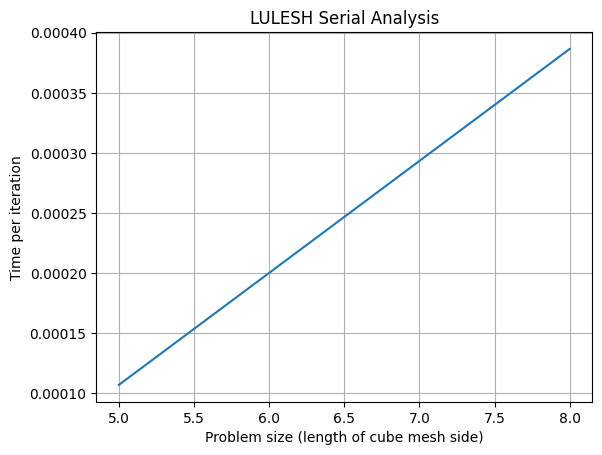

In [5]:

t = np.array(outputs_dict['Time'])
iterations = np.array(outputs_dict['Cycles'])

print("time/iteration: ", t/iterations)

t_per_iter = t/iterations

fig, ax = plt.subplots()
ax.plot(lulesh_s_param, t_per_iter)

ax.set(xlabel='Problem size (length of cube mesh side)', ylabel='Time per iteration',
       title='LULESH Serial Analysis')
ax.grid()

fig.savefig(plot_directory+"test.png")

plt.show()
